# FIS0173: Modello di Ising
<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

Il modello di Ising (dal nome del fisico Ernst Ising che lo ha ideato) è un modello fisico-matematico studiato in meccanica statistica. Esso è definito su un insieme discreto di variabili, libere di assumere i valori +1 o −1, che costituiscono i nodi di un reticolo. Possiamo immaginare ciascun nodo come un "atomo" il cui momento magnetico elementare o "spin" può allinearsi in due direzioni, su (+1) o giù (-1). I nodi $S_i$ interagiscono a coppie: l'energia ha un dato valore quando i due nodi di una coppia sono eguali e un altro quando sono diversi. 

Il modello di Ising riveste un ruolo importante nella teoria delle transizioni di fase. Nel 1936 Peierls congetturò che i modelli di Ising in 2 e 3 dimensioni ammettono transizioni di fase. Nel 1944 Onsager risolse il modello di Ising in 2 dimensioni su un reticolo quadrato e mostrò analiticamente che il sistema è soggetto ad una transizione di fase del second'ordine per un valore della temperatura critica
$$T_c=\frac{2J}{\ln(1+\sqrt{2})}=2.269J.$$ 
Per $T<T_c$, il sistema magnetizza (lo stato è ordinato in virtù delle interazioni locali tra spin). Per $T>T_c$, il sistema paramagnetizza (lo stato è disordinato).

La Hamiltoniana del sistema è
$$\mathcal{H}=-J\sum_{\langle ij\rangle}S_iS_j$$
dove gli spin $S_i$ possono assumere valori +1 o -1, $\langle ij\rangle$ denota l'interazione tra primi vicini, e $J>0$ è la forza dell'interazione.

Si definiscono le quantità seguenti:
- magnetizzazione media
$$ \langle M\rangle =\frac{1}{N}\sum_i S_i$$
- magnetizzazione assoluta media
$$ \left|\langle M\rangle\right| =\frac{1}{N}\left|\sum_i S_i\right|$$
- calore specifico
$$C=\frac{1}{N}\frac{1}{T}(⟨E^2⟩−⟨E⟩^2)$$
- suscettibilità magnetica
$$
\chi=\frac{1}{N}\frac{1}{T}(⟨M^2⟩−⟨|M|⟩^2)
$$

## Inizializzazione ed esplorazione
Prima di tutto carichiamo le librerie e i dati che ci servono per questo esercizio. I dati corrispondono a 1024 configurazioni differenti del modello di ising bidimensionale su un reticolo di dimensione $10\times 10$ per 32 valori di temperatura. Queste configurazioni sono state generate con l'[algoritmo di Metropolis](https://phas.ubc.ca/~berciu/TEACHING/PHYS503/PROJECTS/05_dominic.pdf).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

data = np.load(u'./data/MC_Ising_2Dsquare_10x10.npz')

Si osservi che i dati hanno estensione .npz. Questa è l'estensione di Numpy per i files compressi. Per visualizzare il loro contenuto si può utilizzare il comando seguente:

In [2]:
data.files

['configs', 'temperatures']

Esploriamo i dati.

In [3]:
configs = data['configs']
T = data['temperatures']

Per ogni valore di temperatura, disegniamo una configurazione random presa dai dati.

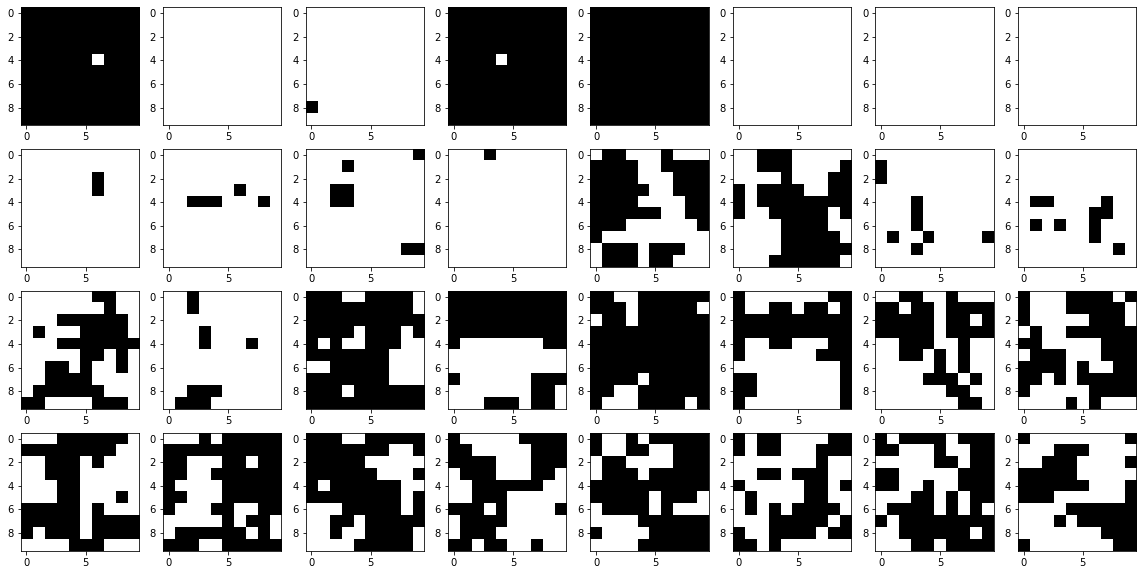

In [4]:
plt.figure(figsize=(20, 10))
for i in range(np.shape(T)[0]):
    j = np.random.randint(0, np.shape(configs)[1])
    plt.subplot(4, 8, i+1)
    plt.imshow(configs[i, j], cmap='Greys', vmin=-1, vmax=1)

Definiamo e calcoliamo le quantità fisiche del modello di Ising.

Text(0.5, 1.0, 'Suscettibilità magnetica')

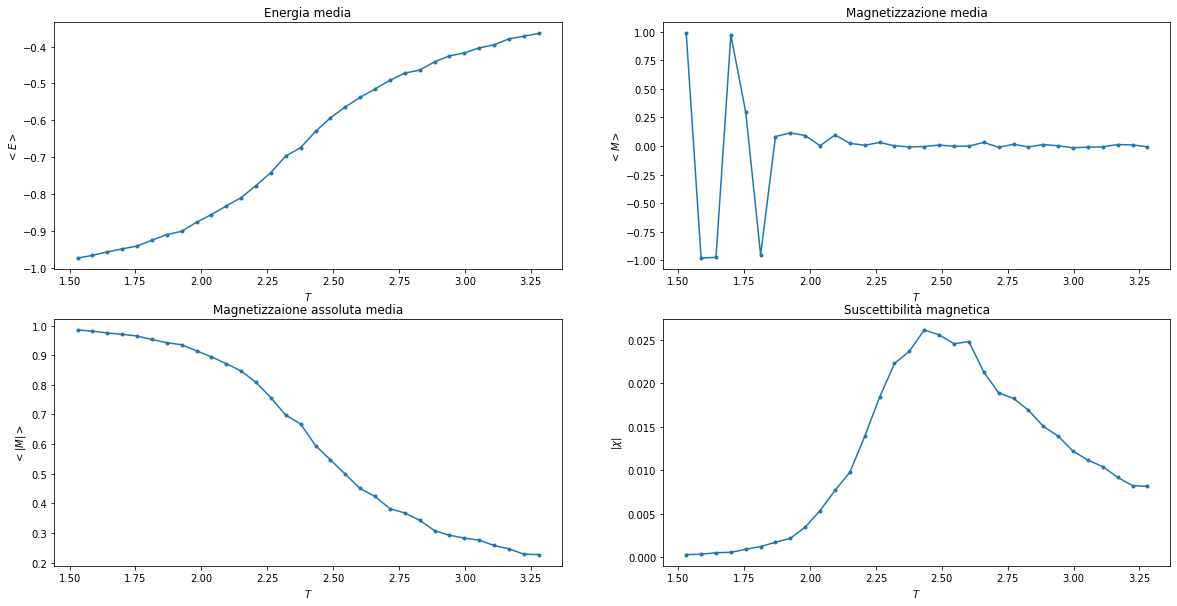

In [5]:
def calc_magnetization_and_susceptibility(configs):
    # the magnetization per configuration is given by the sum of all spins, here we take the absolute magnetization
    # sum over each configuration and normalize
    Mag = np.sum(configs, axis=(2, 3))
    Mag = np.divide(Mag, np.shape(configs)[2] * np.shape(configs)[3])
    AbsMag = np.abs(Mag)
    MagSq = np.square(AbsMag)
    #sum over configs per temperature
    Mag = np.sum(Mag, axis=1) / np.shape(configs)[1]
    AbsMag = np.sum(AbsMag, axis=1) / np.shape(configs)[1]
    MagSq = np.sum(MagSq, axis=1) / np.shape(configs)[1]
    Chi = np.divide(np.add(MagSq, -np.square(AbsMag)), T)
    return Mag, AbsMag, Chi

def calc_energy(configs):
    # the energy per configuration can be determined from the Hamiltonian
    Energy = np.zeros(np.shape(configs)[0])
    for t in range(np.shape(configs)[0]):
        En = 0
        for c in range(np.shape(configs)[1]):
            # For each configuration, calculate the energy by multiplying each site with its 
            # horizontal and vertical nearest neighbour and summing the total
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=0)))
            En += np.sum(np.multiply(-configs[t, c], np.roll(configs[t, c], 1, axis=1)))
        En /= 2 * np.shape(configs)[1] * np.shape(configs)[2] * np.shape(configs)[3]
        Energy[t] = En
    return Energy

Mag, AbsMag, Chi = calc_magnetization_and_susceptibility(configs)
Energy = calc_energy(configs)

plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(T, Energy, '.-')
plt.xlabel('$T$')
plt.ylabel('$<E>$')
plt.title('Energia media')

plt.subplot(2, 2, 2)
plt.plot(T, Mag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<M>$')
plt.title('Magnetizzazione media')

plt.subplot(2, 2, 3)
plt.plot(T, AbsMag, '.-')
plt.xlabel('$T$')
plt.ylabel('$<|M|>$')
plt.title('Magnetizzaione assoluta media')

plt.subplot(2, 2, 4)
plt.plot(T, Chi, '.-')
plt.xlabel('$T$')
plt.ylabel('$|\chi|$')
plt.title('Suscettibilità magnetica')

## Analisi delle componenti principali

Manipoliamo i dati in modo che siano nella forma matriciale desiderata.

In [6]:
configs_PCA = np.reshape(configs, (-1, np.shape(configs)[2] * np.shape(configs)[3]))
(n,m)=np.shape(configs_PCA)
z = np.zeros((n,m))

T_PCA = np.zeros((1,np.shape(configs)[0] * np.shape(configs)[1]))
module=np.zeros((len(T),np.shape(configs)[1]))
for i in range(len(T)):
    module[i]=np.tile(T[i],np.shape(configs)[1])
T_PCA=np.concatenate(module, axis=None)

Centriamo e normalizziamo i dati in modo da lavorare sulla matrice di correlazione anziché sulla matrice di covarianza.

In [7]:
configs_PCA_mean = np.mean(configs_PCA,axis=0)
configs_PCA_stdv = np.std(configs_PCA,axis=0,ddof=0)
for i in range(m):
    z[:,i]=(configs_PCA_mean[i]-configs_PCA[:,i])

Calcoliamo la matrice di correlazione

In [8]:
cov = np.cov(z,rowvar=False)

Troviamo i suoi autovalori e i suoi autovettori.

In [9]:
eigensystem=np.linalg.eig(cov)

Visualizziamo gli autovalori dal maggiore al minore.

Text(0.5, 1.0, 'Autovalori della matrice di correlazione')

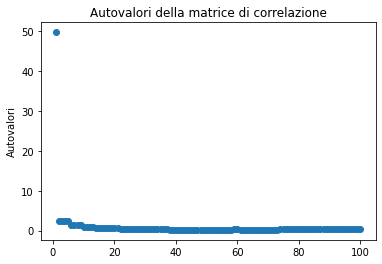

In [10]:
n = []
for i in range(1,m+1):
  n.append(i)
plt.scatter(n[0:100],eigensystem[0][0:100])
plt.ylabel("Autovalori")
plt.title("Autovalori della matrice di correlazione")

Proiettiamo i dati sulle prime due componenti principali.

In [11]:
def reduce_system(U,dimension):
    U_reduced=U[ : , :dimension]
    reduced_vec=np.dot(z,U_reduced)
    var=np.sum(eigensystem[0][:dimension])/np.sum(eigensystem[0][:])
    return reduced_vec,var

reducevec, vari = reduce_system(eigensystem[1],2)

Visualizziamo i risultati.

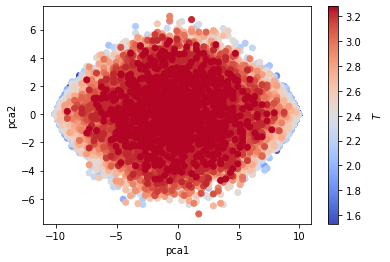

In [12]:
plt.scatter(reducevec[:,0],reducevec[:,1],c=T_PCA,cmap="coolwarm") 
plt.xlabel('pca1')
plt.ylabel('pca2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)

Lo stesso risultato si può ottenere in modo immediato usando [scikit-learn](https://scikit-learn.org/stable/).

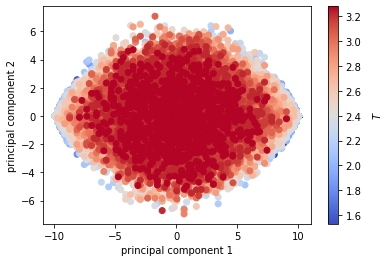

[[10.0622134  -0.01153734]
 [10.0622134  -0.01153734]
 [10.0622134  -0.01153734]
 ...
 [-3.33663924  2.29806138]
 [-2.94246833 -2.96236865]
 [ 2.85103086  0.98324887]]


In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(configs_PCA)
plt.scatter(principalComponents[:,0],principalComponents[:,1],c=T_PCA,cmap="coolwarm") 
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)
plt.show()
print(principalComponents)

Uno dei vantaggi di una tecnica lineare come la PCA consiste nella sua interpretabilità. Le componenti principali hanno una chiara relazione con i dati originali. Può essere utile disegnare le componenti principali, trasformandole in due dimensioni (come i dati originali).

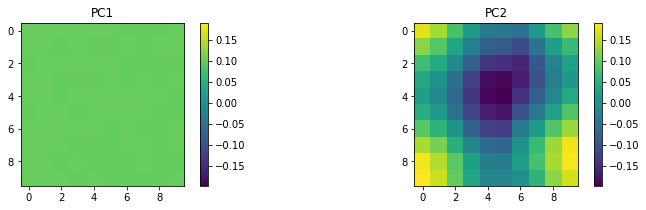

In [14]:
eigen_vectors = eigensystem[1]
PC_transformed = np.reshape(eigen_vectors, (np.shape(configs)[2], np.shape(configs)[3], np.shape(eigen_vectors)[1]))

vmin = np.amin(eigen_vectors[:, 0:2])
vmax = np.amax(eigen_vectors[:, 0:2])
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
plt.imshow(PC_transformed[:, :, 0], vmin=vmin, vmax=vmax)
plt.title('PC1')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(np.roll(PC_transformed[:, :, 1], 6), vmin=vmin, vmax=vmax)
plt.title('PC2')
plt.colorbar()